In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import os, random, h5py
import cv2
from scipy import ndimage
from skimage.transform import rotate
from skimage.exposure import equalize_adapthist
from sklearn.model_selection import train_test_split

In [3]:
FolderPath = "../../dataset/ultrasound_nerve_segmentation/"

In [4]:
print("Load Data...")
trainImages = np.load(FolderPath + 'trainImages.npy')
trainMasks = np.load(FolderPath + 'trainMasks.npy')

Load Data...


In [5]:
def exposure_image(X):
    Xf = np.array(X)
    for i in xrange(X.shape[0]):
        Xf[i] = equalize_adapthist(X[i])
    return Xf

In [6]:
def preprocess_image(X,y):
    X = (X / 255.).astype(np.float32)
    y = (y / 255.).astype(np.float32)

    X = exposure_image(X)
    
    return X,y

In [7]:
def random_rotate90(X,y):
    Xf = np.array(X)
    yf = np.array(y)
    for i in xrange(X.shape[0]):
        rand_deg = np.random.randint(0,4) * 90 #0, 90, 180, 270 deg
        
        Xf[i] = rotate(X[i], rand_deg, mode='constant', preserve_range=True)
        yf[i] = rotate(y[i], rand_deg, mode='constant', preserve_range=True)
    return Xf,yf    

In [8]:
def random_rotate(X,y,intensity):
    Xf = np.array(X)
    yf = np.array(y)
    for i in xrange(X.shape[0]):
        delta = 30. * intensity # scale using augmentation intensity
        ran_delta = random.uniform(-delta, delta)
        
        Xf[i] = rotate(X[i], ran_delta, mode = 'constant', preserve_range=True)
        yf[i] = rotate(y[i], ran_delta, mode = 'constant', preserve_range=True)
    return Xf,yf

In [9]:
def random_flip(X,y):
    ud_indices = random.sample(range(X.shape[0]), int(X.shape[0])/2)
    lr_indices = random.sample(range(X.shape[0]), int(X.shape[0])/2)
    Xf = np.array(X)
    yf = np.array(y)
    
    Xf[ud_indices] = np.flipud(X[ud_indices])
    yf[ud_indices] = np.flipud(y[ud_indices])
    Xf[lr_indices] = np.fliplr(Xf[lr_indices])
    yf[lr_indices] = np.fliplr(yf[lr_indices])
    
    return Xf,yf    

In [10]:
def random_horizontal_flip(X,y):
    flip_indices = random.sample(range(X.shape[0]), int(X.shape[0])/2)
    Xf = np.array(X)
    yf = np.array(y)
    
    Xf[flip_indices] = X[flip_indices, :, ::-1]
    yf[flip_indices] = y[flip_indices, :, ::-1]
    
    return Xf,yf

In [11]:
def vertical_flip(X,y):
    Xf = np.array(X)
    yf = np.array(y)
    for i in xrange(X.shape[0]):
        Xf[i] = rotate(X[i], 180, mode='edge', preserve_range=True)
        yf[i] = rotate(y[i], 180, mode='edge', preserve_range=True)
    return Xf,yf

In [12]:
def vertical_flip_cv2(X,y):
    Xf = np.array(X)
    yf = np.array(y)
    (h,w) = Xf.shape[1:]
    center = (w/2, h/2)
    for i in xrange(X.shape[0]):
        M = cv2.getRotationMatrix2D(center, 180, 1.0)
        
        Xf[i] = cv2.warpAffine(X[i], M, (w,h), flags=cv2.INTER_LINEAR)
        yf[i] = cv2.warpAffine(y[i], M, (w,h), flags=cv2.INTER_LINEAR)
    return Xf,yf

In [13]:
def random_rotate_cv2(X,y,intensity):
    Xf = np.array(X)
    yf = np.array(y)
    (h,w) = Xf.shape[1:]
    center = (w/2, h/2)
    for i in xrange(X.shape[0]):
        delta = 30. * intensity
        ran_delta = random.uniform(-delta, delta)
        M = cv2.getRotationMatrix2D(center, ran_delta, 1.0)
        
        Xf[i] = cv2.warpAffine(X[i], M, (w,h), flags=cv2.INTER_LINEAR)
        yf[i] = cv2.warpAffine(y[i], M, (w,h), flags=cv2.INTER_LINEAR)
        
    return Xf,yf

In [14]:
def random_shift(X,y):
    pass

In [15]:
#test code
X_test, y_test = trainImages[0:5,:], trainMasks[0:5,:]
testX, testy = random_rotate(X_test, y_test,0.3)
testX, testy = random_flip(testX, testy)
testX, testy = random_rotate90(testX, testy)

In [16]:
X_test.shape, testX.shape

((5, 420, 580), (5, 420, 580))

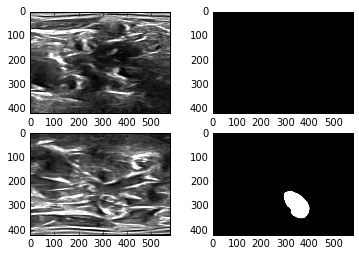

In [17]:
#test code
test_idx = random.randint(0,4)
plt.figure(200)
plt.subplot(221)
plt.imshow(X_test[test_idx,:,:],cmap='gray')

plt.subplot(222)
plt.imshow(y_test[test_idx,:,:],cmap='gray')

plt.subplot(223)
plt.imshow(testX[test_idx,:,:],cmap='gray')

plt.subplot(224)
plt.imshow(testy[test_idx,:,:],cmap='gray')

In [19]:
print("Start random rotate")
tr_trainImages, tr_trainMasks = random_rotate(trainImages, trainMasks,0.3)

Start random rotate


In [20]:
print("Start flip horizontal")
tr_trainMasks, tr_trainMasks = random_flip(tr_trainImages, tr_trainMasks)

Start flip horizontal


In [21]:
#print("Start flip vertical")
tr_trainImages, tr_trainMasks = random_rotate90(tr_trainImages, tr_trainMasks)

In [22]:
# trainImages.shape, tr_trainImages.shape

In [23]:
print("Start concatenate")
Train = np.concatenate((trainImages, tr_trainImages), axis=0)
Masks = np.concatenate((trainMasks, tr_trainMasks), axis=0)

Start concatenate


In [24]:
# Train = trainImages
# Masks = trainMasks

In [25]:
print("Saving preprocessed dataset")
np.save(FolderPath + "Train.npy", Train)
np.save(FolderPath + "Masks.npy", Masks)
with h5py.File(FolderPath + "Train.h5", "w") as hf:
    hf.create_dataset("Train", data=Train)
with h5py.File(FolderPath + "Masks.h5", "w") as hf:
    hf.create_dataset("Masks", data=Masks)
print("Done")

Saving preprocessed dataset


In [26]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(Train,
                                                    Masks,
                                                    test_size=0.2,
                                                    random_state=42)

In [27]:
print("Saving data to file...")
# np.save(FolderPath + "X_Train.npy", X_Train)
# np.save(FolderPath + "Y_Train.npy", Y_Train)
# np.save(FolderPath + "X_Test.npy", X_Test)
# np.save(FolderPath + "Y_Test.npy", Y_Test)
with h5py.File(FolderPath + "X_Train.h5", "w") as hf:
    hf.create_dataset("X_Train", data=X_Train)
with h5py.File(FolderPath + "Y_Train.h5", "w") as hf:
    hf.create_dataset("Y_Train", data=Y_Train)
with h5py.File(FolderPath + "X_Test.h5", "w") as hf:
    hf.create_dataset("X_Test", data=X_Test)
with h5py.File(FolderPath + "Y_Test.h5", "w") as hf:
    hf.create_dataset("Y_Test", data=Y_Test)
print("Done")

Saving data to file...
Done
